# Project 1

In [83]:
import math
import collections
import os

import scipy
from scipy.linalg import expm
import numpy as np
import pandas as pd

import networkx as nx
from networkx.algorithms import community
from community import community_louvain
from networkx.algorithms.community import LFR_benchmark_graph
from networkx.algorithms.community.label_propagation import label_propagation_communities

from sklearn.metrics.cluster import normalized_mutual_info_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from scipy.stats import pearsonr
import osmnx as ox
ox.config(log_console=True, use_cache=True)
ox.__version__


'0.10'

Useful functions

In [2]:
def visualize2(G, big=False):
    if big:
        plt.figure(figsize=(12, 8))
        
    labels = G.nodes()
    pos=nx.spring_layout(G)
    
    # nodes
    nx.draw_networkx_nodes(G,pos,node_size=700)

    # edges
    nx.draw_networkx_edges(G,pos,
                        width=6,alpha=0.5,edge_color='b',style='dashed')

    # labels
    nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

    plt.axis('off')
    plt.show() # display


In [3]:
def degree_distribution(G, hist=False):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    
    if hist:
        plt.hist(vk, bins=range(0, maxk+1), normed=True)
        plt.ylabel("Pk", fontsize=15)
        plt.xlabel("Degree", fontsize=15)
        plt.title("Degree distribution", fontsize=20)
        plt.grid(True)
        plt.show(True)
    
    return kvalues, Pk

In [4]:
def draw_centrality_hist(centralities, title="Defaul title", ylabel="Default ylabel", xlabel="Defaul xlabel"):
    """
    centralities = np.array(centralities)
    maxk = np.max(centralities)
    mink = np.min(centralities)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    """
    
    plt.figure(figsize=(6,4))
    #plt.hist(centralities, bins=range(0, maxk+1), normed=True)
    plt.hist(centralities, density=True)
    plt.title(title, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show(True)

In [5]:
def acc(G):
    N = len(G.nodes)
    vk = dict(G.degree())
    vk = list(vk.values())
    A = nx.adjacency_matrix(G)
    P = np.zeros((N,N), dtype = 'float')
    for i in np.arange(0, N):
        for j in np.arange(0, N):
            if(vk[i] > 0):
                P[i,j] = A[i,j]/vk[i]
    P2 = expm(P)/np.exp(1)
    vacc = np.zeros(N, dtype = float)
    for i in np.arange(0, N):
        acc = 0
        for j in np.arange(0,N):
            if(P2[i,j] > 0):
                acc = acc + P2[i,j]*np.log(P2[i,j])
        acc = np.exp(-acc)
        vacc[i] = acc
    return vacc

In [6]:
def calc_knn(graph):
    knn = []
    for i in graph.nodes():
        aux =  nx.average_neighbor_degree(graph, nodes = [i])
        knn.append(float(aux[i]))
    return np.array(knn) 

In [7]:
def calc_knn_k(vk, knn, plot=False):
    knnk = list()
    ks = list()
    for k in np.arange(np.min(vk), np.max(vk)):
        aux = vk == k
        if(len(knn[aux]) > 0):
            av_knn = np.mean(knn[aux]) #average clustering among all the nodes with degree k
            knnk.append(av_knn)
            ks.append(k)
            
    if plot:
        plt.plot(ks, knnk, 'ro')
        #plt.loglog(ks,knnk,'bo',basex=10,basey=10)
        #plt.title("Average neighborhood connectivity vs degree")
        plt.ylabel("knn(k)")
        plt.xlabel("k")
        plt.grid(True)
        plt.savefig('knnk.eps')

        # determine best fit line
        par = np.polyfit(ks, knnk, 1, full=True)
        slope=par[0][0]
        intercept=par[0][1]
        xl = [min(ks), max(ks)]
        yl = [slope*xx + intercept  for xx in xl]
        plt.plot(xl, yl, '-b')
        plt.savefig('knn.eps') #save the figure into a file
        plt.show(True)
        
    return ks, knn

Load necessary datasets into all_graphs

In [90]:
# Read all the data we will use now and in the future
all_graphs = {}
all_graphs["E-road"] = nx.read_edgelist("data/euroroad.txt")

all_graphs["Proteins"] = nx.read_edgelist("data/out.proteins", comments="%")

all_graphs["Hamster"] = nx.read_edgelist("data/out.petster-friendships-hamster-uniq", comments="%")

all_graphs["C Elegans 2004"] = nx.read_edgelist("data/wi2004.txt", comments="#")
all_graphs["C Elegans 2007"] = nx.read_edgelist("data/wi2007.txt", comments="#")

all_graphs["US Power Grid"] = nx.read_gml("data/uspowergrid.gml", label="id")

all_graphs["C elegans"] = nx.MultiGraph()
all_graphs["C elegans"] = nx.read_gml("data/celegansneural.gml")
all_graphs["C elegans"] = nx.Graph(all_graphs["C elegans"])
all_graphs["C elegans"] = nx.convert_node_labels_to_integers(all_graphs["C elegans"], first_label=0)

all_graphs["US Airports"] = nx.Graph()
all_graphs["US Airports"] = nx.read_edgelist("data/USairport500.txt", nodetype=int, data=(('weight',float),))

# Read from csv file
df = pd.read_csv('data/rdependencies.csv')
all_graphs["R Dependencies"] = nx.from_pandas_edgelist(df, source="from", target="to", edge_attr=None)

# Cities' networks
all_graphs["Motuca"] = ox.graph_from_place('Motuca', network_type='drive', simplify=False)
all_graphs["Mombuca"] = ox.graph_from_place('Mombuca', network_type='drive', simplify=False)
all_graphs["Guatapara"] = ox.graph_from_place('Guatapara', network_type='drive', simplify=False)
all_graphs["Rincao"] = ox.graph_from_place('Rincao', network_type='drive', simplify=False)

# Convert data to undirected and remove loops
for graph in all_graphs.keys():
    all_graphs[graph] = all_graphs[graph].to_undirected()
    if graph != "R Dependencies":
          all_graphs[graph].remove_edges_from(nx.selfloop_edges(all_graphs[graph]))

# Q1

In [9]:
def q1centralities(net):
    centralities = {}
    centralities["Degree"] = list(dict(all_graphs[net].degree()).values())
    centralities["K-Core"] = list(dict(nx.core_number(all_graphs[net])).values())
    centralities["Closeness"] = list(dict(nx.closeness_centrality(all_graphs[net])).values())
    centralities["Betweenness"] = list(dict(nx.betweenness_centrality(all_graphs[net])).values())
    centralities["Eigenvector"] = list(dict(nx.eigenvector_centrality(all_graphs[net], max_iter = 1000)).values())
    centralities["Pagerank"] = list(dict(nx.pagerank(all_graphs[net], alpha=0.85)).values())
    centralities["Accessibility"] = acc(all_graphs[net])
    #centralities["Communicability"] = list(dict(nx.communicability_betweenness_centrality(all_graphs[net])).values())
    # TODO: USAR ACIMA
        
    return centralities
        

In [10]:
def correlationMatrix(centralities):
    df = pd.DataFrame(centralities)
    corr = df.corr()
    plt.figure(figsize=(8,8))
    plt.imshow(corr, cmap='Blues', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(corr)), corr.columns, rotation='vertical', fontsize=20)
    plt.yticks(range(len(corr)), corr.columns, fontsize=20);
    plt.suptitle('Correlation between centrality measures', fontsize=20)
    plt.grid(False)
    plt.show()

==================================== E-road Correlation Matrix ====================================


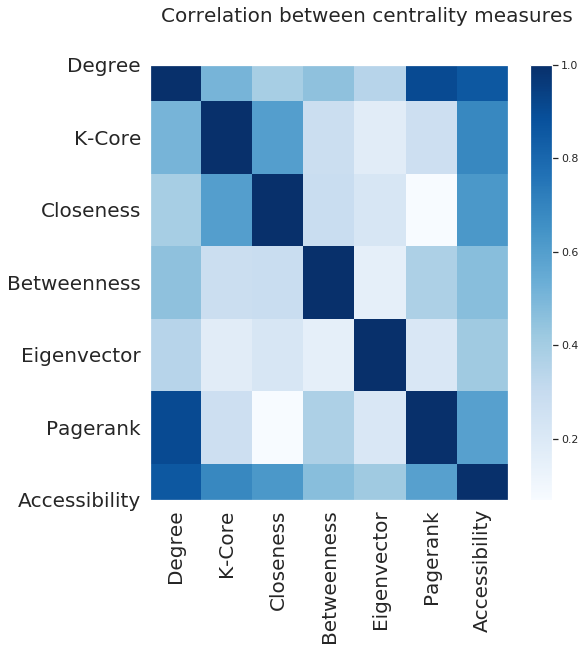

In [11]:
# q1nets = ["E-road", "Hamster", "C elegans", "US Airports"]
q1nets = ["E-road"] # TODO: USAR ACIMA

for net in q1nets:
    print("==================================== " + net + " Correlation Matrix ====================================")
    correlationMatrix(q1centralities(net))

# Q2

## I) Motuca

### Degree

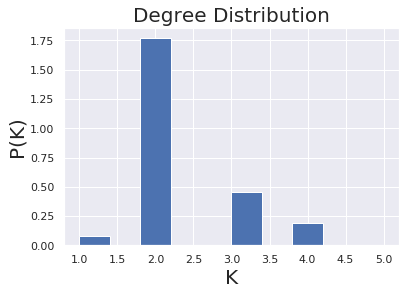

In [12]:
vk = list(dict(all_graphs["Motuca"].degree()).values())

draw_centrality_hist(vk, title="Degree Distribution", ylabel="P(K)", xlabel="K")

### Closeness Centrality

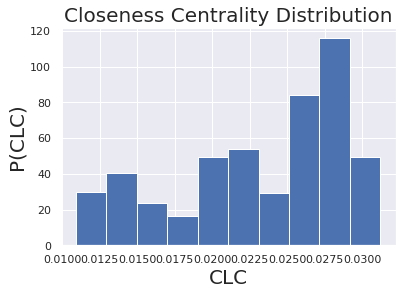

In [13]:
CLC = list(dict(nx.closeness_centrality(all_graphs["Motuca"])).values())

draw_centrality_hist(CLC, title="Closeness Centrality Distribution", ylabel="P(CLC)", xlabel="CLC")

### Betweeness Centrality

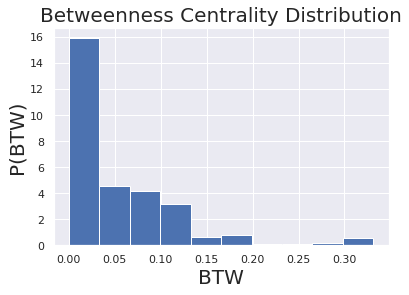

In [14]:
BTW = list(dict(nx.betweenness_centrality(all_graphs["Motuca"])).values())

draw_centrality_hist(BTW, title="Betweenness Centrality Distribution", ylabel="P(BTW)", xlabel="BTW")

## II) Mombuca

### Degree

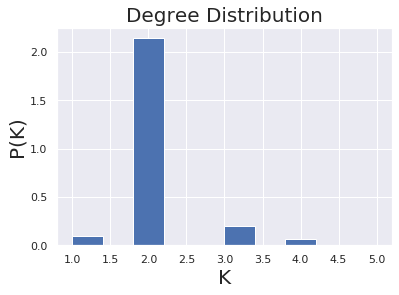

In [15]:
vk = list(dict(all_graphs["Mombuca"].degree()).values())

draw_centrality_hist(vk, title="Degree Distribution", ylabel="P(K)", xlabel="K")

### Closeness Centrality

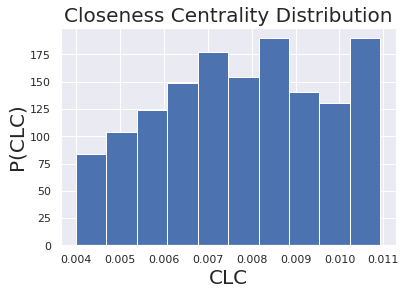

In [16]:
CLC = list(dict(nx.closeness_centrality(all_graphs["Mombuca"])).values())

draw_centrality_hist(CLC, title="Closeness Centrality Distribution", ylabel="P(CLC)", xlabel="CLC")

### Betweeness Centrality

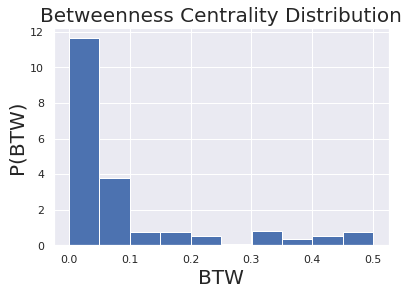

In [17]:
BTW = list(dict(nx.betweenness_centrality(all_graphs["Mombuca"])).values())

draw_centrality_hist(BTW, title="Betweenness Centrality Distribution", ylabel="P(BTW)", xlabel="BTW")

## III) Guatapara

### Degree

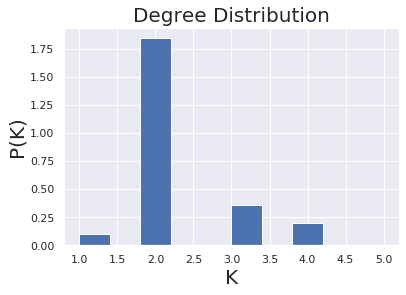

In [18]:
vk = list(dict(all_graphs["Guatapara"].degree()).values())

draw_centrality_hist(vk, title="Degree Distribution", ylabel="P(K)", xlabel="K")

### Closeness Centrality

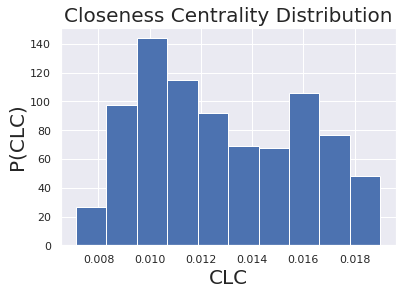

In [19]:
CLC = list(dict(nx.closeness_centrality(all_graphs["Guatapara"])).values())

draw_centrality_hist(CLC, title="Closeness Centrality Distribution", ylabel="P(CLC)", xlabel="CLC")

### Betweeness Centrality

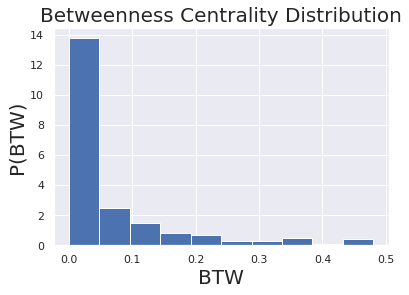

In [20]:
BTW = list(dict(nx.betweenness_centrality(all_graphs["Guatapara"])).values())

draw_centrality_hist(BTW, title="Betweenness Centrality Distribution", ylabel="P(BTW)", xlabel="BTW")

## IV) Rincão

### Degree

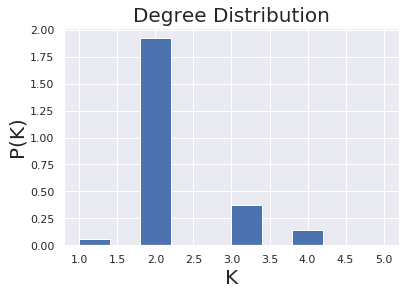

In [21]:
vk = list(dict(all_graphs["Rincao"].degree()).values())

draw_centrality_hist(vk, title="Degree Distribution", ylabel="P(K)", xlabel="K")

### Closeness Centrality

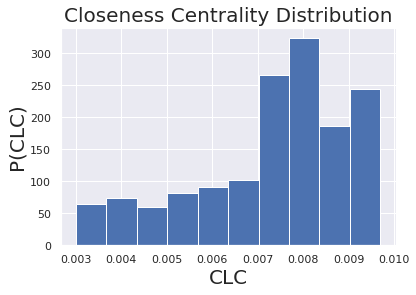

In [22]:
CLC = list(dict(nx.closeness_centrality(all_graphs["Rincao"])).values())

draw_centrality_hist(CLC, title="Closeness Centrality Distribution", ylabel="P(CLC)", xlabel="CLC")

### Betweeness Centrality

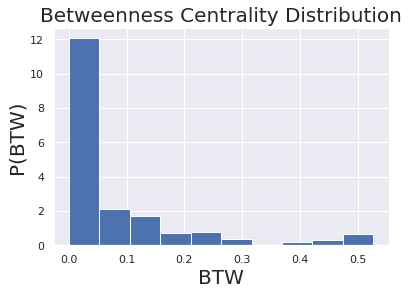

In [23]:
BTW = list(dict(nx.betweenness_centrality(all_graphs["Rincao"])).values())

draw_centrality_hist(BTW, title="Betweenness Centrality Distribution", ylabel="P(BTW)", xlabel="BTW")

TODO: Interpretação dos resultados (placeholder)

# Q3

In [24]:
def q3centralities(nets):
    for net in nets:
        print("=============== " + net + " ===============")
        
        degree_cent = list(dict(all_graphs[net].degree()).values())
        draw_centrality_hist(degree_cent, title="Degree Centrality Histogram", ylabel="P(K)", xlabel="K")
        
        closeness_cent = list(dict(nx.closeness_centrality(all_graphs[net])).values())
        draw_centrality_hist(closeness_cent, title="Closeness Centrality Histogram", ylabel="P(CLC)", xlabel="CLC")
        
        eigenvector_cent = list(dict(nx.eigenvector_centrality(all_graphs[net], max_iter = 1000)).values())
        draw_centrality_hist(eigenvector_cent, title="Eigenvector Centrality Histogram", ylabel="P(EC)", xlabel="EC")
        
        pagerank_cent = list(dict(nx.pagerank(all_graphs[net], alpha=0.85)).values())
        draw_centrality_hist(pagerank_cent, title="Pagerank Centrality Histogram", ylabel="P(PR)", xlabel="PR")

=============== C Elegans 2004 ===============


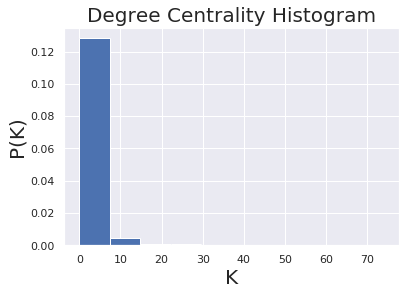

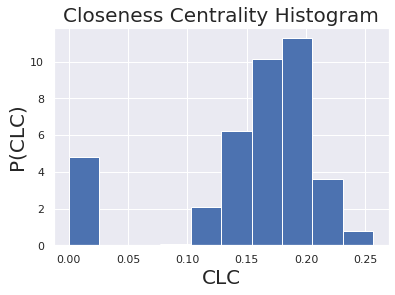

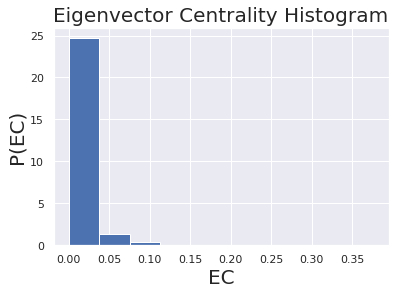

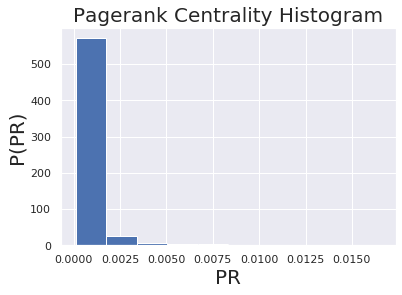

In [25]:
# q3nets = ["Proteins", "C Elegans 2004", "C Elegans 2007", "US Power Grid"]    
q3nets = ["C Elegans 2004"]    # TODO: usar a linha de cima (demora) e deixar bonito
q3centralities(q3nets)

TODO: interpretar resultados

# Q4

In [26]:
def q4centralities(net):
    degree_cent = list(dict(all_graphs[net].degree()).values())
    kcore_cent = list(dict(nx.core_number(all_graphs[net])).values())
    closeness_cent = list(dict(nx.closeness_centrality(all_graphs[net])).values())
    betweenness_cent = list(dict(nx.betweenness_centrality(all_graphs[net])).values())
    eigenvector_cent = list(dict(nx.eigenvector_centrality(all_graphs[net], max_iter = 1000)).values())
    pagerank_cent = list(dict(nx.pagerank(all_graphs[net], alpha=0.85)).values())
    accessibility_cent = acc(all_graphs[net])
    communicability_cent = list(dict(nx.communicability_betweenness_centrality(all_graphs[net])).values())
        
    return [degree_cent, kcore_cent, closeness_cent, betweenness_cent, eigenvector_cent, pagerank_cent,
           accessibility_cent, communicability_cent]
        

In [27]:
def q4measures(centralities):
    measures = []
    
    for centralitiy in centralities:
        average = np.mean(centrality)
        standard_deviation = np.std(centrality)
        second_moment = scipy.stats.moment(centrality, moment=2)
        shannon_entropy = scipy.stats.entropy(centrality)
        measures.append([average, standard_deviation, second_moment, shannon_entropy])
        
    return measures.flatten()

In [ ]:
# q4nets = ["Proteins", "C Elegans 2004", "C Elegans 2007", "US Power Grid"]
q4nets = ["C Elegans 2004"] # TODO: USAR ACIMA

features = []
for net in q4nets:
    features.append(q4measures(q4centralities(net)))

/usr/lib/python3.7/site-packages/networkx/algorithms/centrality/subgraph_alg.py:246: RuntimeWarning: invalid value encountered in true_divide
  B = (expA - scipy.linalg.expm(A.A)) / expA


TODO: fazer o PCA

# Q5

In [ ]:
def q5correlations(graph):
    # First calculate knn
    knn = calc_knn(graph)
    
    # Now calculate vk
    vk = dict(graph.degree())
    vk = list(vk.values())
    
    # From knn and vk, calculate ks and knn(k)
    ks, knnk = calc_knn_k(vk, knn, plot=True) # also, plot the scatter graph
    
    # Pearson correlation coefficient
    rho = np.corrcoef(ks, knnk)[0,1]
    print('Pearson correlation coefficient:', rho)
    r = nx.degree_assortativity_coefficient(graph)
    print("Assortativity coefficient:", r)


In [ ]:
# q5nets = ["E-road", "C elegans", "US Airports", "Proteins"]
q5nets = ["E-road"] # TODO: Usar a linha acima

for net in q5nets:
    q5correlations(all_graphs[net])

TODO: fix and interpret results

# Q6

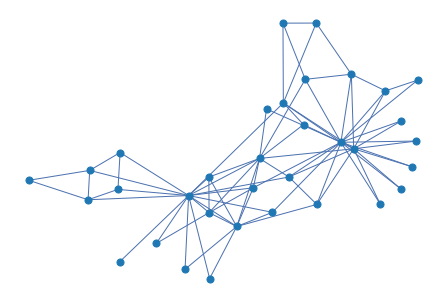

In [60]:
N = 128
tau1 = 3
tau2 = 1.5
mu = 0.04
k =16
minc = 32
maxc = 32
G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                        max_degree = k, min_community=minc, max_community = maxc, seed = 1120)

pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, nodecolor='r', edge_color='b', 
        node_size=50, font_size=16,  width=1,pos = pos)
plt.show(True)

### Girvan-Newman

In [3]:
gn_communities = community.girvan_newman(G)
k = 4
for i in np.arange(0, k-1):
    next_level_communities = next(gn_communities)
gn_communities = sorted(map(sorted, next_level_communities))
for comm in gn_communities:
    print('community:', comm)

community: [0, 5, 10, 16, 17, 20, 23, 28, 30, 31, 36, 38, 40, 42, 44, 57, 61, 65, 70, 74, 75, 79, 83, 96, 97, 102, 103, 104, 111, 124, 125, 126]
community: [1, 4, 7, 12, 13, 26, 45, 46, 47, 49, 51, 52, 54, 60, 63, 64, 67, 68, 69, 73, 80, 82, 85, 91, 93, 101, 107, 108, 109, 115, 122, 127]
community: [2, 3, 8, 14, 15, 19, 22, 24, 25, 29, 32, 33, 34, 50, 53, 59, 72, 77, 78, 81, 84, 87, 88, 89, 90, 92, 94, 100, 105, 117, 118, 120]
community: [6, 9, 11, 18, 21, 27, 35, 37, 39, 41, 43, 48, 55, 56, 58, 62, 66, 71, 76, 86, 95, 98, 99, 106, 110, 112, 113, 114, 116, 119, 121, 123]


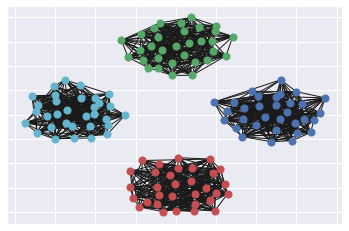

In [4]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure()
aux = 0
for comm in gn_communities:
    nx.draw_networkx(G.subgraph(comm), pos=pos, node_color = colors[aux], with_labels = False, node_size=50)
    aux = aux + 1
plt.show(True)

### Fastgreedy

TODO: FIX

In [27]:
# Save G as edgelist
nx.write_edgelist(G, "ex6.pairs")

In [33]:
str_command1 = 'FastCommunity_GPL_v1.0.3/./FastCommunityMH -s -f ex6.pairs'
os.system(str_command1 + ' -l firstRun')

32256

### Label Propagation

In [57]:
label_prop_comm = list(label_propagation_communities(G))
for comm in label_prop_comm:
    print(comm)

{2, 3, 8, 14, 15, 19, 22, 24, 25, 29, 32, 33, 34, 50, 53, 59, 72, 77, 78, 81, 84, 87, 88, 89, 90, 92, 94, 100, 105, 117, 118, 120}
{6, 9, 11, 18, 21, 27, 35, 37, 39, 41, 43, 48, 55, 56, 58, 62, 66, 71, 76, 86, 95, 98, 99, 106, 110, 112, 113, 114, 116, 119, 121, 123}
{1, 4, 7, 12, 13, 26, 45, 46, 47, 49, 51, 52, 54, 60, 63, 64, 67, 68, 69, 73, 80, 82, 85, 91, 93, 101, 107, 108, 109, 115, 122, 127}
{0, 5, 10, 16, 17, 20, 23, 28, 30, 31, 36, 38, 40, 42, 44, 57, 61, 65, 70, 74, 75, 79, 83, 96, 97, 102, 103, 104, 111, 124, 125, 126}


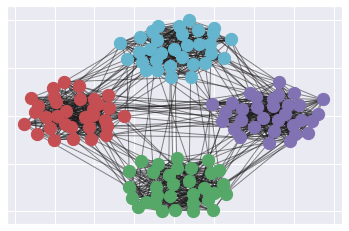

In [58]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = len(label_prop_comm)
count = 0.
for com in label_prop_comm :
    count = count + 1.
    list_nodes = com
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Louvain

In [7]:
louv_partition = community_louvain.best_partition(G)

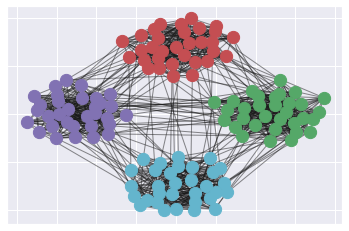

In [9]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = float(len(set(louv_partition.values())))
count = 0.
for com in set(louv_partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in louv_partition.keys() if louv_partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Normalized Mutual Information Score

In [42]:
normalized_mutual_info_score(louv_partition)

TypeError: normalized_mutual_info_score() missing 1 required positional argument: 'labels_pred'

TODO: FIX NORMALIZED MUTUAL INFORMATION SCORE

# Q7

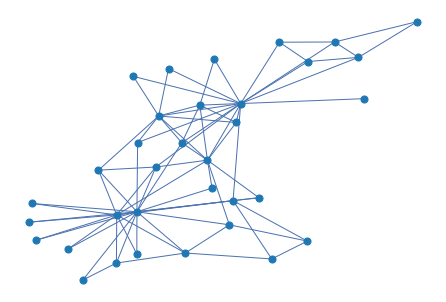

In [61]:
G = nx.read_edgelist("data/zachary.txt", nodetype=int)
G = G.to_undirected()
G = nx.convert_node_labels_to_integers(G, first_label=0)

pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, nodecolor='r', edge_color='b', 
        node_size=50, font_size=16,  width=1,pos = pos)
plt.show(True)

TODO: netcarto + informap

### Girvan-Newman

In [62]:
gn_communities = community.girvan_newman(G)
k = 4
for i in np.arange(0, k-1):
    next_level_communities = next(gn_communities)
gn_communities = sorted(map(sorted, next_level_communities))
for comm in gn_communities:
    print('community:', comm)

community: [0, 1, 3, 7, 10, 11, 12, 13, 14, 15]
community: [2, 8, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
community: [4, 5, 6, 9, 22]
community: [18]


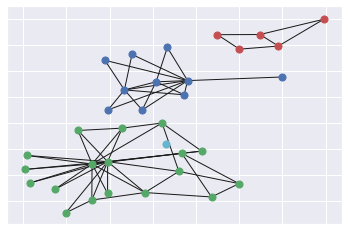

In [63]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure()
aux = 0
for comm in gn_communities:
    nx.draw_networkx(G.subgraph(comm), pos=pos, node_color = colors[aux], with_labels = False, node_size=50)
    aux = aux + 1
plt.show(True)

### Fastgreedy

TODO: FIX

In [27]:
# Save G as edgelist
nx.write_edgelist(G, "ex6.pairs")

In [33]:
str_command1 = 'FastCommunity_GPL_v1.0.3/./FastCommunityMH -s -f ex6.pairs'
os.system(str_command1 + ' -l firstRun')

32256

### Label Propagation

In [66]:
label_prop_comm = list(label_propagation_communities(G))
for comm in label_prop_comm:
    print(comm)

{9, 4}
{0, 1, 2, 3, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}
{5, 6, 22}


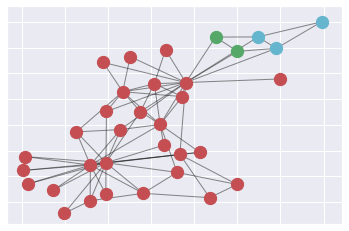

In [67]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = len(label_prop_comm)
count = 0.
for com in label_prop_comm :
    count = count + 1.
    list_nodes = com
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Louvain

In [64]:
louv_partition = community_louvain.best_partition(G)

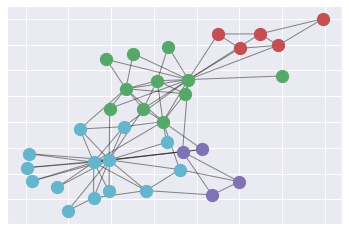

In [65]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = float(len(set(louv_partition.values())))
count = 0.
for com in set(louv_partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in louv_partition.keys() if louv_partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# Q8

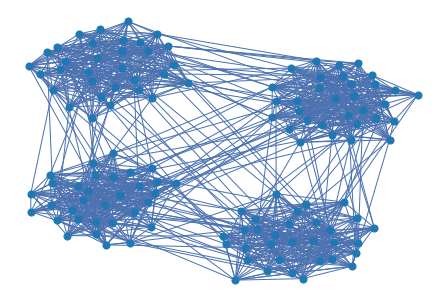

In [68]:
N = 128
tau1 = 3
tau2 = 1.5
mu = 0.04
k =16
minc = 32
maxc = 32
G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                        max_degree = k, min_community=minc, max_community = maxc, seed = 1120)

pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, nodecolor='r', edge_color='b', 
        node_size=50, font_size=16,  width=1,pos = pos)
plt.show(True)

### Girvan-Newman

In [69]:
gn_communities = community.girvan_newman(G)
k = 4
for i in np.arange(0, k-1):
    next_level_communities = next(gn_communities)
gn_communities = sorted(map(sorted, next_level_communities))
for comm in gn_communities:
    print('community:', comm)

community: [0, 5, 10, 16, 17, 20, 23, 28, 30, 31, 36, 38, 40, 42, 44, 57, 61, 65, 70, 74, 75, 79, 83, 96, 97, 102, 103, 104, 111, 124, 125, 126]
community: [1, 4, 7, 12, 13, 26, 45, 46, 47, 49, 51, 52, 54, 60, 63, 64, 67, 68, 69, 73, 80, 82, 85, 91, 93, 101, 107, 108, 109, 115, 122, 127]
community: [2, 3, 8, 14, 15, 19, 22, 24, 25, 29, 32, 33, 34, 50, 53, 59, 72, 77, 78, 81, 84, 87, 88, 89, 90, 92, 94, 100, 105, 117, 118, 120]
community: [6, 9, 11, 18, 21, 27, 35, 37, 39, 41, 43, 48, 55, 56, 58, 62, 66, 71, 76, 86, 95, 98, 99, 106, 110, 112, 113, 114, 116, 119, 121, 123]


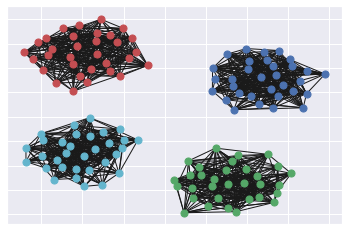

In [70]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure()
aux = 0
for comm in gn_communities:
    nx.draw_networkx(G.subgraph(comm), pos=pos, node_color = colors[aux], with_labels = False, node_size=50)
    aux = aux + 1
plt.show(True)

### Fastgreedy

TODO: FIX

In [27]:
# Save G as edgelist
nx.write_edgelist(G, "ex6.pairs")

In [33]:
str_command1 = 'FastCommunity_GPL_v1.0.3/./FastCommunityMH -s -f ex6.pairs'
os.system(str_command1 + ' -l firstRun')

32256

### Label Propagation

In [71]:
label_prop_comm = list(label_propagation_communities(G))
for comm in label_prop_comm:
    print(comm)

{2, 3, 8, 14, 15, 19, 22, 24, 25, 29, 32, 33, 34, 50, 53, 59, 72, 77, 78, 81, 84, 87, 88, 89, 90, 92, 94, 100, 105, 117, 118, 120}
{6, 9, 11, 18, 21, 27, 35, 37, 39, 41, 43, 48, 55, 56, 58, 62, 66, 71, 76, 86, 95, 98, 99, 106, 110, 112, 113, 114, 116, 119, 121, 123}
{1, 4, 7, 12, 13, 26, 45, 46, 47, 49, 51, 52, 54, 60, 63, 64, 67, 68, 69, 73, 80, 82, 85, 91, 93, 101, 107, 108, 109, 115, 122, 127}
{0, 5, 10, 16, 17, 20, 23, 28, 30, 31, 36, 38, 40, 42, 44, 57, 61, 65, 70, 74, 75, 79, 83, 96, 97, 102, 103, 104, 111, 124, 125, 126}


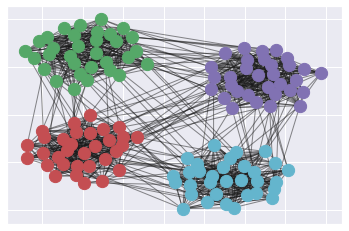

In [72]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = len(label_prop_comm)
count = 0.
for com in label_prop_comm :
    count = count + 1.
    list_nodes = com
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Louvain

In [73]:
louv_partition = community_louvain.best_partition(G)

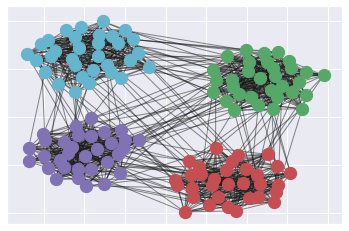

In [74]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = float(len(set(louv_partition.values())))
count = 0.
for com in set(louv_partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in louv_partition.keys() if louv_partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Normalized Mutual Information Score

In [75]:
normalized_mutual_info_score(louv_partition)

TypeError: normalized_mutual_info_score() missing 1 required positional argument: 'labels_pred'

TODO: FIX NORMALIZED MUTUAL INFORMATION SCORE

# Q9

In [92]:
def q9properties(net):
    properties = {}
    
    properties["N"] = len(net.nodes)
    properties["av_degree"] = np.mean(np.array(list(dict(net.degree()).values())))
    properties["assortativity"] = nx.degree_assortativity_coefficient(net)
    properties["av_shortest_path_length"] = nx.average_shortest_path_length(net)

    # Modularity
    # TODO: include fast greedy
    properties["louv_partition"] = community_louvain.best_partition(G)
    properties["label_prop_comm"] = np.array(list(label_propagation_communities(G)))
    properties["gn_communities"] = community.girvan_newman(G)
    
    return properties

In [102]:
def print_louv_partition(comm):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    size = float(len(set(comm.values())))
    count = 0.
    for com in set(comm.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in comm.keys() if comm[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

In [107]:
def print_label_prop_comm(comm):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    size = len(label_prop_comm)
    count = 0.
    for com in label_prop_comm :
        count = count + 1.
        list_nodes = com
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 150, node_color = colors[int(count)])
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

In [105]:
def print_gn_communities(comm):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    plt.figure()
    aux = 0
    for comm in gn_communities:
        nx.draw_networkx(G.subgraph(comm), pos=pos, node_color = colors[aux], with_labels = False, node_size=50)
        aux = aux + 1
    plt.show(True)

========== C elegans ==========
N 297
av_degree 14.464646464646465
assortativity -0.16319921031570409
av_shortest_path_length 2.455318955318955
louv_partition {0: 0, 1: 1, 2: 2, 3: 2, 4: 1, 5: 0, 6: 3, 7: 1, 8: 2, 9: 3, 10: 0, 11: 3, 12: 1, 13: 1, 14: 2, 15: 2, 16: 0, 17: 0, 18: 3, 19: 2, 20: 0, 21: 3, 22: 2, 23: 0, 24: 2, 25: 2, 26: 1, 27: 3, 28: 0, 29: 2, 30: 0, 31: 0, 32: 2, 33: 2, 34: 2, 35: 3, 36: 0, 37: 3, 38: 0, 39: 3, 40: 0, 41: 3, 42: 0, 43: 3, 44: 0, 45: 1, 46: 1, 47: 1, 48: 3, 49: 1, 50: 2, 51: 1, 52: 1, 53: 2, 54: 1, 55: 3, 56: 3, 57: 0, 58: 3, 59: 2, 60: 1, 61: 0, 62: 3, 63: 1, 64: 1, 65: 0, 66: 3, 67: 1, 68: 1, 69: 1, 70: 0, 71: 3, 72: 2, 73: 1, 74: 0, 75: 0, 76: 3, 77: 2, 78: 2, 79: 0, 80: 1, 81: 2, 82: 1, 83: 0, 84: 2, 85: 1, 86: 3, 87: 2, 88: 2, 89: 2, 90: 2, 91: 1, 92: 2, 93: 1, 94: 2, 95: 3, 96: 0, 97: 0, 98: 3, 99: 3, 100: 2, 101: 1, 102: 0, 103: 0, 104: 0, 105: 2, 106: 3, 107: 1, 108: 1, 109: 1, 110: 3, 111: 0, 112: 3, 113: 3, 114: 3, 115: 1, 116: 3, 117: 2, 118: 2

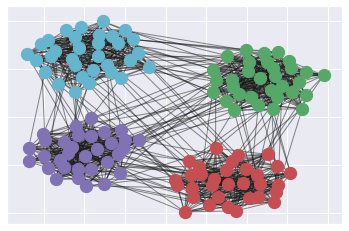

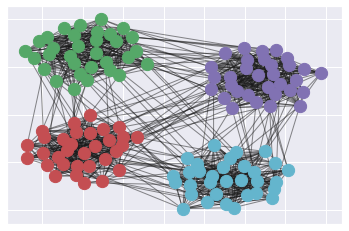

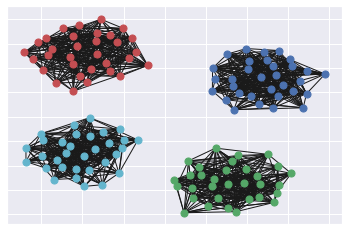

In [108]:
# q9nets = ["E-road", "C elegans", "US Airports", "Proteins"] TODO: USE THIS
q9nets = ["C elegans"]

for net in q9nets:
    print("========== " + net + " ==========")
    properties = q9properties(all_graphs[net])
    for prop in properties:
        print(prop, properties[prop])
    print_louv_partition(properties["louv_partition"])
    print_label_prop_comm(properties["label_prop_comm"])
    print_gn_communities(properties["gn_communities"])
    # printCommunity(properties["louv_partition"]) TODO: INCLUDE FAST GREEDY
    

TODO: conclusion